In [6]:
import json
import pandas as pd
import matplotlib.pyplot as plt

with open("experiment_with_heart_rate.json", "r", encoding="utf-8") as f:
    participants = json.load(f)

## A. Plot heart rate over the entire experiment (one participant)

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# -------- 1) helper: read raw HR CSV --------
def load_hr_file(path: str) -> pd.DataFrame:
    """
    Load a participantN.csv HR file into a DataFrame with:
    RR, ArtifactCorrectedRR, RawArtifact, ts
    """
    lines = Path(path).read_text(encoding="utf-8").splitlines()

    # find header line (the one containing RR and ts)
    header_idx = None
    for i, line in enumerate(lines):
        if "RR" in line and "ts" in line:
            header_idx = i
            break
    if header_idx is None:
        raise ValueError(f"Could not find header with 'RR' and 'ts' in {path}")

    header_line = lines[header_idx].strip()

    # detect delimiter
    if ";" in header_line and "," not in header_line:
        delim = ";"
    else:
        delim = ","

    header = [h.strip() for h in header_line.split(delim)]

    # data rows
    data_rows = []
    for line in lines[header_idx + 1 :]:
        if not line.strip():
            continue
        parts = [p.strip() for p in line.split(delim)]
        if len(parts) != len(header):
            continue
        data_rows.append(parts)

    df = pd.DataFrame(data_rows, columns=header)

    # numeric columns
    for col in ["RR", "ArtifactCorrectedRR", "RawArtifact"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    if "RawArtifact" in df.columns:
        df["RawArtifact"] = df["RawArtifact"].fillna(0).astype(int)

    if "ts" in df.columns:
        df["ts"] = pd.to_datetime(df["ts"], errors="coerce")

    df = df.dropna(subset=["ts", "ArtifactCorrectedRR"])
    return df

# -------- 2) plot raw HR from CSV (no video cutting) --------
def plot_raw_hr_csv(participant_id: int):
    path = f"hr_data/participant{participant_id}.csv"  # adjust folder if needed
    df = load_hr_file(path)

    df["RR_seconds"] = df["ArtifactCorrectedRR"] / 1000.0

    plt.figure(figsize=(14, 4))
    plt.plot(df["ts"], df["RR_seconds"], marker=".", linestyle="-")
    plt.title(f"Raw Heart Rate from CSV – Participant {participant_id}")
    plt.xlabel("Time")
    plt.ylabel("RR interval (seconds)")
    plt.grid(True)
    plt.show()


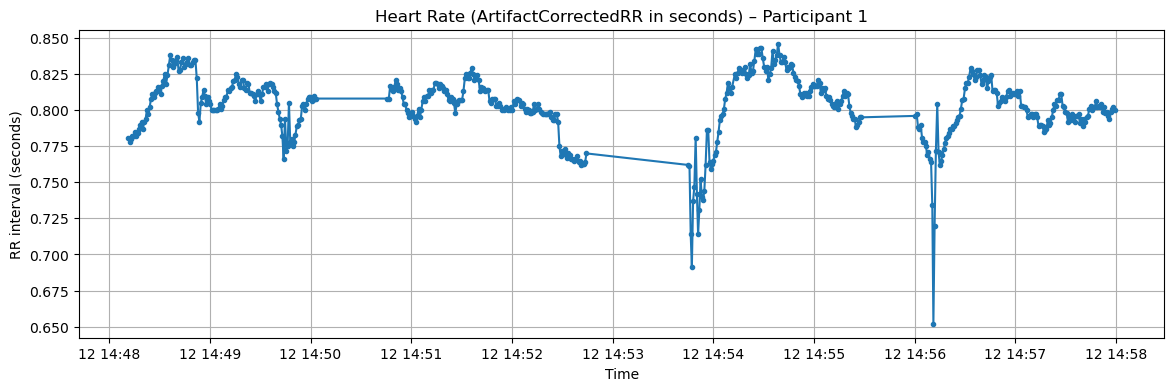

In [21]:
plot_full_hr(1)


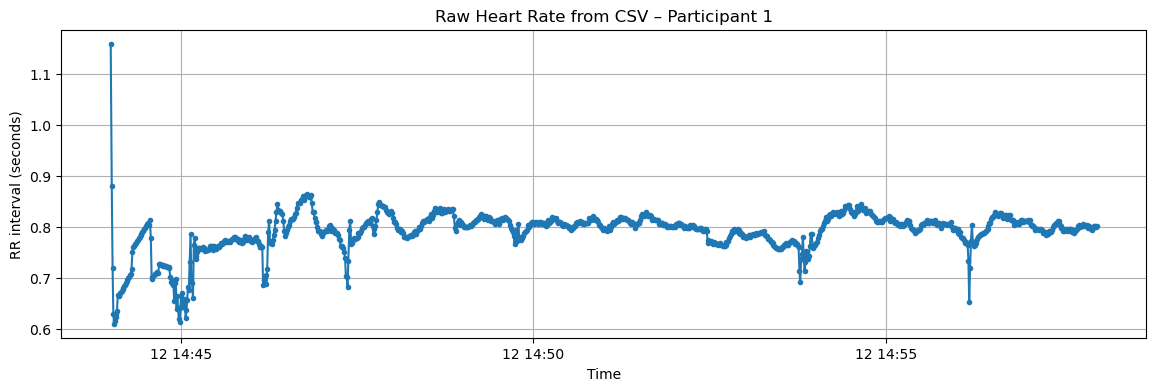

In [22]:
plot_raw_hr_csv(1)


## B. Plot heart rate per video

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_hr_by_video(participant_id):
    # find participant in JSON
    p = next(pp for pp in participants if pp["participant_id"] == participant_id)

    n = len(p["stimuli"])
    if n == 0:
        print("No stimuli for this participant")
        return

    fig, axes = plt.subplots(n, 1, figsize=(14, 3 * n), sharex=True)
    if n == 1:
        axes = [axes]  # make iterable

    for i, (stim, ax) in enumerate(zip(p["stimuli"], axes)):
        df = pd.DataFrame(stim.get("heart_rate", []))

        if df.empty or "ts" not in df.columns or "ArtifactCorrectedRR" not in df.columns:
            ax.text(0.5, 0.5, "No HR data", ha="center", va="center", transform=ax.transAxes)
            ax.set_title(f"Video {stim['id']} – {stim['video_id']}")
            ax.grid(True)
            continue

        # robust datetime parsing
        df["ts"] = pd.to_datetime(df["ts"], errors="coerce")

        # convert ms → seconds
        df["RR_seconds"] = df["ArtifactCorrectedRR"] / 1000.0

        # drop bad rows and sort
        df = df.dropna(subset=["ts", "RR_seconds"]).sort_values("ts")

        ax.plot(df["ts"], df["RR_seconds"], marker=".", linestyle="-")
        ax.set_title(f"Video {stim['id']} – {stim['video_id']}")
        ax.set_ylabel("RR (s)")
        ax.grid(True)

    axes[-1].set_xlabel("Time")
    fig.tight_layout()
    plt.show()


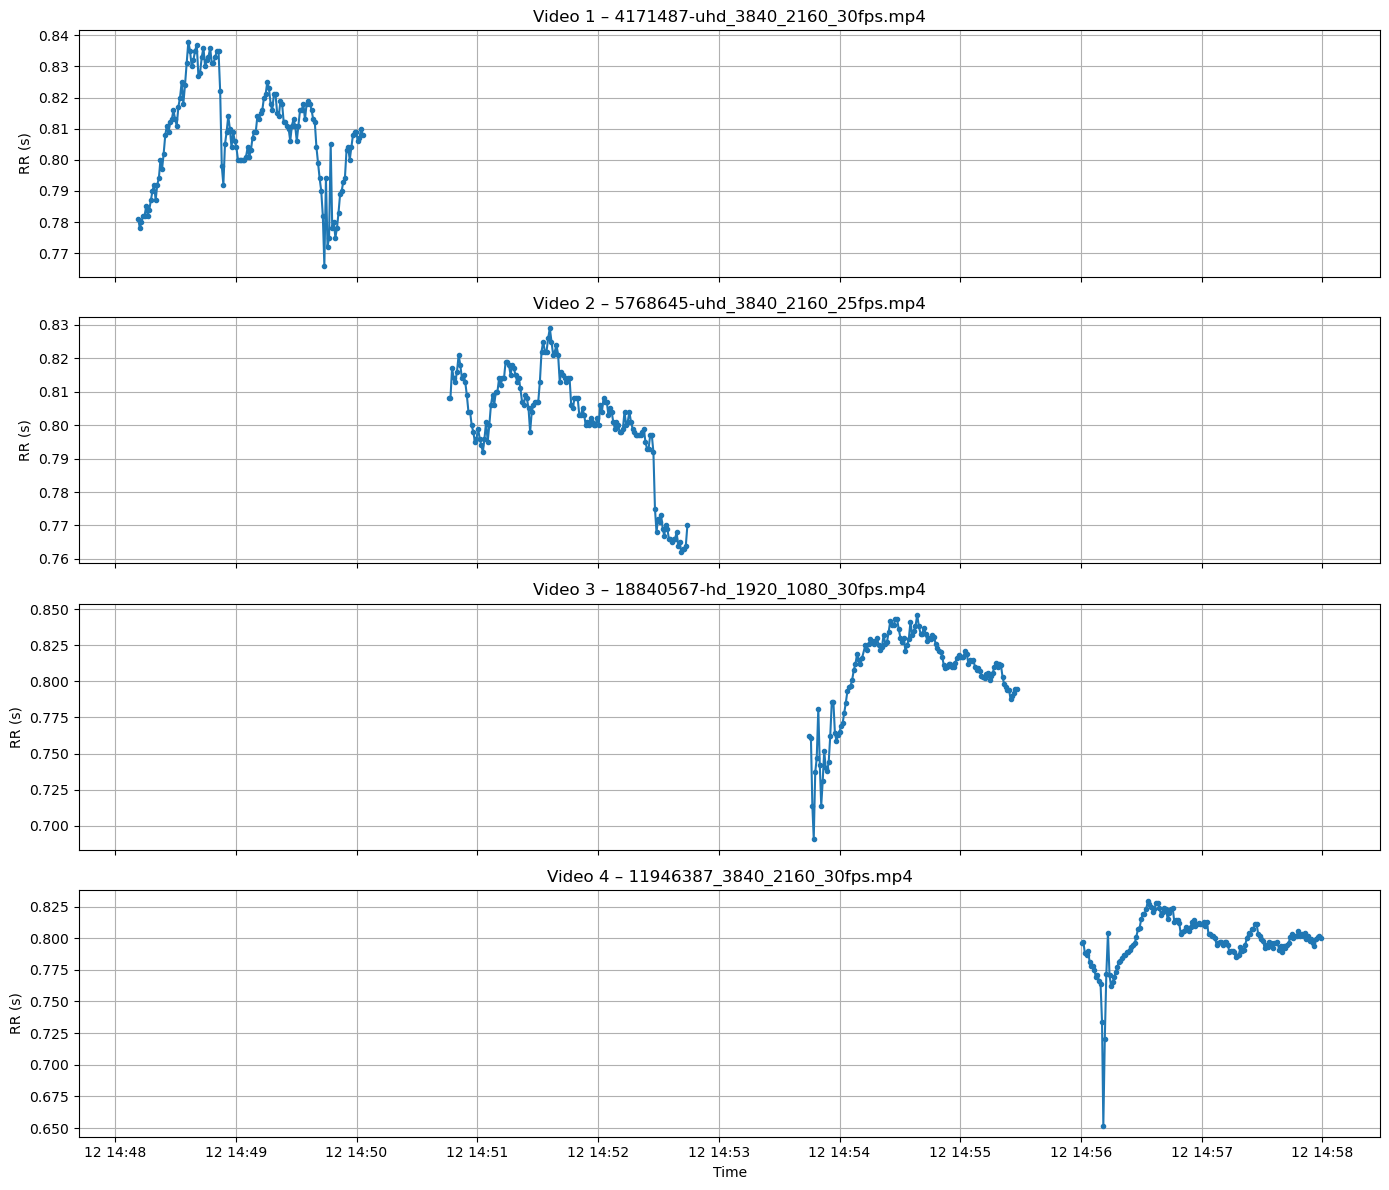

In [27]:
plot_hr_by_video(1)

## C. Plot whole experiment with video boundaries

In [ ]:
def plot_hr_with_videos(participant_id):
    p = next(pp for pp in participants if pp["participant_id"] == participant_id)

    # gather HR data
    rows = []
    for stim in p["stimuli"]:
        rows.extend(stim["heart_rate"])
    df = pd.DataFrame(rows)
    df["ts"] = pd.to_datetime(df["ts"])

    plt.figure(figsize=(16, 4))
    plt.plot(df["ts"], df["RR"], color="black", linewidth=1, label="Heart Rate (RR)")

    # add video start/end markers
    for stim in p["stimuli"]:
        if stim["video_start"] and stim["video_end"]:
            start = pd.to_datetime(stim["video_start"])
            end = pd.to_datetime(stim["video_end"])
            plt.axvline(start, color="green", linestyle="--", alpha=0.7)
            plt.axvline(end, color="red", linestyle="--", alpha=0.7)
            plt.text(start, df["RR"].max(), f"Video {stim['id']}", rotation=90, verticalalignment="top")

    plt.title(f"Heart Rate with Video Boundaries — Participant {participant_id}")
    plt.xlabel("Time")
    plt.ylabel("RR interval (ms)")
    plt.grid(True)
    plt.show()


plot_hr_with_videos(1)
